### 1. Dataset

In [1]:
%%time
import os
import logging
from marss2l.utils import setup_stream_logger, get_remote_filesystem, pathjoin

logger = logging.getLogger(__name__)
setup_stream_logger(logger, level=logging.DEBUG)

os.makedirs("figures", exist_ok=True)

CPU times: user 1.62 s, sys: 1.71 s, total: 3.34 s
Wall time: 1.45 s


In [2]:
from marss2l import loaders
fs = get_remote_filesystem()

Using account key


We are using the test set to figure out the MDL:

In [3]:
from marss2l import loaders
# Import the dataset
# csv_path = "az://imeodata/models/data/marss2l_20250302/validated_images_all.csv"
csv_path = "marss2l_20250302/validated_images_all.csv"
dataframe_data_traintest = loaders.read_csv(csv_path, 
                                            add_columns_for_analysis=True, 
                                            split="all",
                                            fs=None)
dataframe_data_traintest.shape

Removed 2 rows with percent_overlap < 0.5


(93581, 57)

In [4]:
# Have a look at the table columns, for reference
dataframe_data_traintest.columns

Index(['id_loc_image', 's2path', 'plumepath', 'cloudmaskpath', 'ch4path',
       'location_name_short', 'wind_u', 'wind_v', 'wind_speed', 'vza', 'sza',
       'percentage_clear', 'tile', 'isplume', 'ch4_fluxrate',
       'ch4_fluxrate_std', 'satellite', 'tile_date', 'notified', 'id_location',
       'last_update', 'location_name', 'country', 'lon', 'lat', 'offshore',
       'sector', 'monitoring', 'observability', 'background_image_tile',
       'footprint', 'plume', 'crs', 'transform_a', 'transform_b',
       'transform_c', 'transform_d', 'transform_e', 'transform_f', 'width',
       'height', 'window_row_off', 'window_col_off', 'window_height',
       'window_width', 'percent_overlap', 'year', 'year_month',
       'year_month_day', 'isplumeneg', 'date', 'satellite_constellation',
       'year_quarter', 'ch4_fluxrate_th', 'interval_ch4_fluxrate',
       'interval_ch4_fluxrate_str', 'split_name'],
      dtype='object')

Statistics are made with true positives

In [6]:
# Take positives only
df_data = dataframe_data_traintest[(dataframe_data_traintest["ch4_fluxrate"] > 0) & (dataframe_data_traintest.split_name == "test_2023")].copy()
# Number of plumes by country
country_tables = df_data['country'].value_counts()
country_tables

country
Turkmenistan                  853
Algeria                       296
United States of America      144
Libya                         121
Syrian Arab Republic           99
Iran (Islamic Republic of)     70
Yemen                          68
Offshore                       39
Kazakhstan                     32
Egypt                          24
Bahrain                        14
Uzbekistan                     11
Saudi Arabia                   10
Kuwait                          9
Iraq                            7
Venezuela                       6
China                           3
India                           2
Oman                            2
Argentina                       1
Jordan                          1
Russian Federation              1
Name: count, dtype: int64

In [7]:
# Intersting countries
countries = ['United States of America', 'Turkmenistan', 'Algeria', 'Libya']
# Fultering by countrues
data = {country:df_data[df_data['country']==country] for country in countries}
# #  Update with offshore
# data.update({'Offshore': df_data[df_data['offshore']==True]})
# countries.append('Offshore')
# Print the number of observations
[print(data[country].shape[0], country) for country in countries]

144 United States of America
853 Turkmenistan
296 Algeria
121 Libya


[None, None, None, None]

### 2. Empirical distributions

Measure the frequency of detections for 200 kg/h interval:

In [8]:
import numpy as np
# Define the bins
bins = range(0, 20000,400)
# Histogram of flowrates
q_hists = {country: np.histogram(data[country]['ch4_fluxrate'], bins = bins, density = True) for country in countries}

Show the results for each satellite:

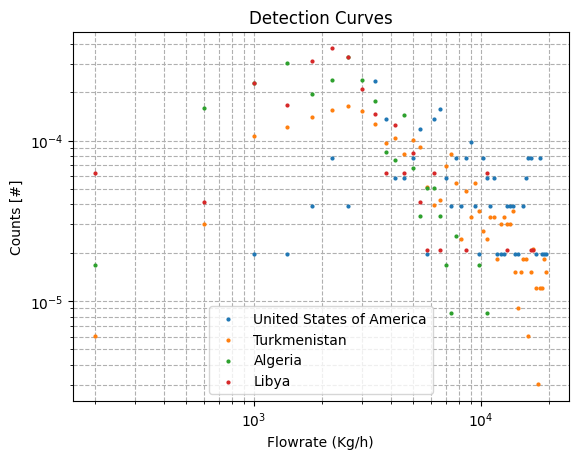

In [9]:
import numpy as np
import matplotlib.pylab as plt
# Centre of the labels
cntr = np.array([(bins[i+1]+bins[i])/2 for i in range(0, len(bins)-1)])
# Show the cumulative count
fig, ax = plt.subplots()
[ax.scatter(cntr, q_hists[country][0], s = 4, label = country) for country in countries]
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlabel("Flowrate (Kg/h)"); ax.set_ylabel('Counts [#]')
ax.set_axisbelow(True)
plt.title('Detection Curves'); plt.grid(True, which="both", ls="--"); plt.legend()

The model that describes the frequencies is the combination of two distribution funcitons: (1) a logistic function that represents the `Probability of Detection (PoD)` and (2) a power law equation representing the `Theoretical Plume Frequency Distribution (PFD)`. The response of every instrument is a combination of the two, which is the PoD multiplied by the PFD.

In [10]:
from scipy.stats import gamma

def pod(x, a, b):
    ''' Probability of detection as logistic function
    :param x: float. Flowrate.
    :param a: float. Steepness.
    :param b: float. Midpoint.
    '''
    # return gamma.pdf(x, a, b, c)
    return 1/(1 + 10**(-a*( x - b)))

def pfd(x, A, B):
    ''' Plume frequency distribution as power law
    :param x: float. Flowrate.
    :param A: float. Slope.
    :param B: float. Bias.
    '''
    return np.exp(A * np.log(x) + B)

def system_equations(x, a, b, A, B):
    # def system_equations(x, a, b, A, B):
    # return pod(x, a, b, c)
    return pod(x, a, b) * pfd(x, A, B)


Fit the equations to the histogram of every satellite:

In [11]:
from scipy.optimize import curve_fit
# Initial guess of the parameters - at the moment, very dependent on initial guess
initial_guess = [1, 1, -1, -1]
initial_guess = [0.001, 1000, -1, -1]
# Initialize the parameters
popts = {}; pcovs = {}
# For every satellite fit the curves
for country in countries:
    # Flowrates as independent, Counts as depedent
    x = cntr; y = q_hists[country][0]
    # Avoid 0 values in counts
    x = x[y > 0]; y = y[y > 0]
    # Compute the parameters
    popt, pcov = curve_fit(system_equations, x, y, p0=initial_guess)
    # Save the results
    popts.update({country: popt})
    pcovs.update({country: pcov})

Prepare a Monte Carlo simulation considering all the uncertainties involved:

In [12]:
# Number of Monte Carlo runs
n = 1000
# Bins to count the frequency of flowrates
cntr = np.array([(bins[i+1]+bins[i])/2 for i in range(0, len(bins)-1)])
# Flowrates to compute the PoD
flw = np.linspace(0, 10000, 10000)
# Save modellign results for reach satellite
model_means = {}; model_sds = {}
pod_means = {}; pod_sds = {}
# For every satellite fit the curves
for country in countries:
    # Results of the simulations of frequencies
    freq = np.ones((n, len(cntr)))
    # Results of the simulations of PoDs
    pods = np.ones((n, len(flw)))
    # Sample the parameter distribution
    params = np.random.multivariate_normal(popts[country], pcovs[country], size = n)
    # Rund the model multiple times
    for i in range(n):
        # Compute the frequencies with these parameters
        freq[i,:] = system_equations(cntr, params[i, 0], params[i, 1], params[i, 2], params[i,3])
        pods[i,:] = pod(flw,  params[i, 0], params[i, 1])
        # Compute the pods
    # Compute statistics
    freq_model_mu = np.mean(freq, axis = 0); model_means.update({country: freq_model_mu})
    freq_model_sd = np.std(freq, axis = 0); model_sds.update({country: freq_model_sd})
    pod_model_mu = np.mean(pods, axis = 0); pod_means.update({country: pod_model_mu})
    pod_model_sd = np.std(pods, axis = 0); pod_sds.update({country: pod_model_sd})

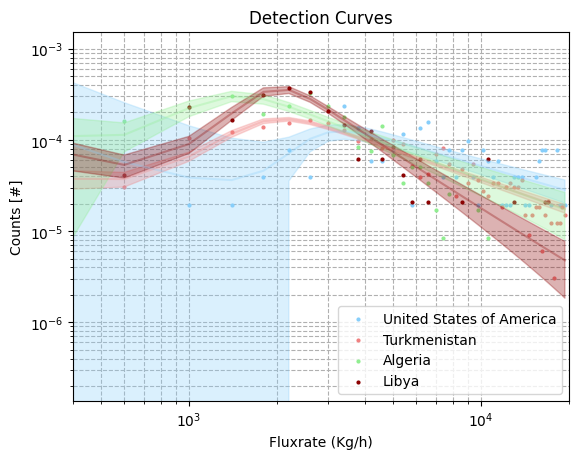

In [13]:
import matplotlib.pylab as plt
# Set the colors and markers
colors = {'United States of America':'lightskyblue', 'Turkmenistan':'lightcoral', 'Algeria':'lightgreen', 'Libya':'darkred', 'offshore': 'lightpink'}
markers = {'United States of America':'o', 'Turkmenistan':'x', 'Algeria':'+', 'Libya':'-', 'offshore': '^'}
# Initialize the plots
fig, ax = plt.subplots()
# Show the frequency dots
[ax.scatter(cntr, q_hists[country][0], s = 4, label = country, color = colors[country]) for country in countries]
# Show the mean value of the curve
[ax.plot(cntr, model_means[country], alpha = 0.3, color = colors[country]) for country in countries]
# And the standard deviations
[ax.fill_between(cntr, 
                 model_means[country]-model_sds[country], 
                 model_means[country]+model_sds[country], 
                 color = colors[country], alpha = 0.3) for country in countries]
# Formatring
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlabel("Fluxrate (Kg/h)"); ax.set_ylabel('Counts [#]')
ax.set_xlim(400,20000)
ax.set_axisbelow(True)
plt.title('Detection Curves'); plt.grid(True, which="both", ls="--"); plt.legend()

In [14]:
# Compute the MDLs at 50 and 90% probability
mdls = {country: [{'Q50_min':int(round(flw[np.where((pod_means[country]+pod_sds[country]) > 0.5)[0][0]]))},
                    {'Q50_mean':int(round(flw[np.where(pod_means[country] > 0.5)[0][0]]))},
                    {'Q50_max':int(round(flw[np.where((pod_means[country]-pod_sds[country]) > 0.5)[0][0]]))},
                    {'Q90_min':int(round(flw[np.where((pod_means[country]+pod_sds[country]) > 0.9)[0][0]]))},
                    {'Q90_mean':int(round(flw[np.where((pod_means[country]) > 0.9)[0][0]]))},
                    # {'Q90_max':int(round(flw[np.where((pod_means[country]-pod_sds[country]) > 0.9)[0][0]]))}
                 ]
            for country in countries}
# Print the results
mdls

{'United States of America': [{'Q50_min': 2222},
  {'Q50_mean': 2511},
  {'Q50_max': 2856},
  {'Q90_min': 2976},
  {'Q90_mean': 3814}],
 'Turkmenistan': [{'Q50_min': 1499},
  {'Q50_mean': 1575},
  {'Q50_max': 1656},
  {'Q90_min': 2165},
  {'Q90_mean': 2294}],
 'Algeria': [{'Q50_min': 988},
  {'Q50_mean': 1131},
  {'Q50_max': 1287},
  {'Q90_min': 1457},
  {'Q90_mean': 1713}],
 'Libya': [{'Q50_min': 1675},
  {'Q50_mean': 1764},
  {'Q50_max': 1853},
  {'Q90_min': 2193},
  {'Q90_mean': 2310}]}

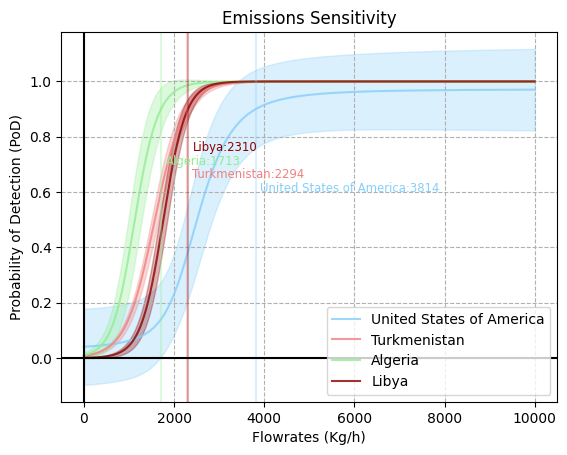

In [15]:
# Show the probabilities of detection for each satellite
fig, ax = plt.subplots()
# Plot every curve
[ax.plot(flw, pod_means[country], alpha = 0.8, label = country, color = colors[country]) for country in countries]
[ax.fill_between(flw,
                 pod_means[country]-pod_sds[country],
                 pod_means[country]+pod_sds[country],
                 alpha = 0.3, color = colors[country]) for country in countries]
# Draw the 90% probability value
[ax.axvline(mdls[country][4]['Q90_mean'], color = colors[country], alpha = 0.3) for i, country in enumerate(countries)]
[ax.text(mdls[country][4]['Q90_mean']+100, (i/2+1)/10+0.5 , country + ':' + str(mdls[country][4]['Q90_mean']), color = colors[country], fontsize = 'small') 
 for i, country in enumerate(countries)]
ax.axhline(0, color = 'black')
ax.axvline(0, color = 'black')
# Insert labels to x and y axes
ax.set_title('Emissions Sensitivity')
ax.set_xlabel('Flowrates (Kg/h)')
ax.set_ylabel('Probability of Detection (PoD)')
# Show the legend and grid
ax.grid(linestyle = '--'); ax.legend()